<a href="https://colab.research.google.com/github/sukmoonlee/JupyterNotebook/blob/main/2020/sensors_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이타 파일 업로드

In [1]:
# 데이타 파일 다운로드

%%capture
!wget https://home.sukmoonlee.com/sensors/202007.log -O data07.log
!wget https://home.sukmoonlee.com/sensors/202008.log -O data08.log
!wget https://home.sukmoonlee.com/sensors/202009.log -O data09.log
!wget https://home.sukmoonlee.com/sensors/202009.log -O data10.log

## 작업을 위한 Colab 준비 (runtime 재시작 필요)

In [2]:
# 한글 폰트 설치
# !apt-get install -y fonts-nanum
# !ls -al /usr/share/fonts/truetype/nanum/*.ttf
# 한국 시간 설정(KST, UTC+9)
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Seoul /etc/localtime

In [3]:
# Colab 사전 준비
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from matplotlib import font_manager, rc
# plt.rcParams['axes.unicode_minus'] = False

# path = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"    
# font_name = font_manager.FontProperties(fname=path).get_name()
# rc('font', family=font_name)
# font_manager._rebuild() 

## 메뉴에서 Runtime --> Restart Runtime 수행 필요 (Runtime을 재시작을 해도 업로드/다운로드 받은 파일은 그대로 유지됨)


def smooth_curve(points, factor = 0.9):
  """ 부드러운 곡선 그래프를 사용하기 위해서 데이타를 변형 """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points 

## 분석을 위한 데이타 준비

In [4]:
import glob

flist = glob.glob("/content/*.log")
for fn in flist :  
  print(fn)

/content/data09.log
/content/data10.log
/content/data07.log
/content/data08.log


In [5]:
# 데이타 추출하기
import subprocess
import shlex
from datetime import datetime

temp_list = list()
for fn in flist :

  cmd = 'egrep "Date|temp1" %s' % fn
  proc = subprocess.Popen(shlex.split(cmd),  stdout=subprocess.PIPE, stderr=subprocess.PIPE)  
  stdout, stderr = proc.communicate()
  lines = stdout.decode().split("\n")

  FLAG_STATE=0
  for line in lines:
    # print(FLAG_STATE, line)
    
    if 'Date:' in line:      
      FLAG_STATE=2
      date1=datetime.strptime(line[6:], "%Y-%m-%d %H:%M:%S")
      # date1 = line[6:]
    elif FLAG_STATE==2:
      FLAG_STATE=3
      temp1=line[15:19]
    elif FLAG_STATE==3:
      FLAG_STATE=1
      temp2=line[15:19]
      line_list = {}
      line_list['datetime']=date1
      line_list['radeon-pci-0008']=temp1
      line_list['k10temp-pci-00c3']=temp2
      temp_list.append(line_list)

      # print(date1,"|",temp1,"|",temp2)

# 후속 작업1 : datetime을 index로 지정 
df = pd.DataFrame(temp_list)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
# 후속작업2 : 문자가 아닌 데이타에 대해서 실수로 지정
df = df.apply(pd.to_numeric, errors='ignore')
df.sort_index(axis=0, ascending=True, inplace=True)
df

,radeon-pci-0008,k10temp-pci-00c3
datetime,,
2020-07-09 20:01:23,60.0,60.0
2020-07-09 20:01:30,59.0,59.9
2020-07-09 20:10:01,60.0,60.0
2020-07-09 20:20:01,60.0,60.1
2020-07-09 20:30:01,61.0,60.0
...,...,...
2020-09-30 23:30:01,57.0,56.6
2020-09-30 23:40:02,57.0,56.5
2020-09-30 23:40:02,57.0,56.5


In [6]:
df.describe()

,radeon-pci-0008,k10temp-pci-00c3
count,15838.000000,15838.000000
mean,59.669782,59.015305
std,1.666085,1.606071
min,47.000000,46.000000
25%,59.000000,58.000000
50%,60.000000,59.100000
75%,61.000000,59.900000
max,67.000000,66.900000


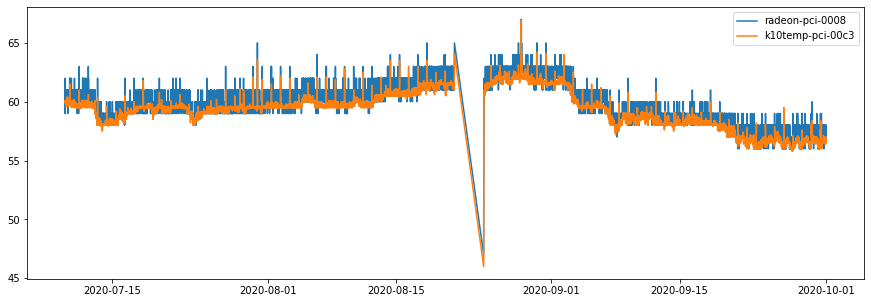

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.legend(df.columns.values)
plt.show()